# Plot validation between SUNTANS, ROMS and mooring data


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
import os
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator


from mycurrents import oceanmooring as om
from soda.utils.modvsobs import ModVsObs

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'




Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


In [2]:
# %matplotlib notebook

In [52]:
def plot_da(mo_T, mo_T_da, titlestr, ymin=-252.5):
    # Mean temp
    ax3=plt.subplot2grid((1,3),(0,0),colspan=1)
    plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
    plt.plot(mo_T_da.meanMod, -mo_T.Z,'ko')
    plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
    plt.xlabel('Temperature [$^{\circ}$C]')
    plt.ylabel('Depth [m]')
    plt.grid(b=True)
    plt.xlim([7,30])
    #plt.legend(('ROMS','ROMS-4DVAR','Obs.'), loc='upper left')
    plt.legend(('verification','posterior','obs.'), loc='best')
    plt.text(0.05,1.01, '(a)', transform=ax3.transAxes)
    plt.ylim(ymin,0)
    # Bias
    ax4=plt.subplot2grid((1,3),(0,1),colspan=1)
    plt.plot(mo_T.bias, -mo_T.Z,'ro')
    plt.plot(mo_T_da.bias, -mo_T_da.Z,'ko')
    plt.xlim(-3.25,3.25)
    ax4.set_xticks([-2,-1,0,1,2])
    ax4.set_yticklabels([])
    plt.xlabel('Bias [$^{\circ}$C]')
    plt.grid(b=True)
    plt.title(titlestr)
    plt.vlines(0,-mo_T.Z[0],-mo_T.Z[-1], 'k', lw=1.5)
    plt.text(0.05,1.01, '(b)', transform=ax4.transAxes)

    plt.ylim(ymin,0)

    # RMSE
    ax5=plt.subplot2grid((1,3),(0,2),colspan=1)
    plt.plot(mo_T.rmse, -mo_T.Z,'ro')
    plt.plot(mo_T_da.rmse, -mo_T_da.Z,'ko')
    plt.xlim(0,3)
    ax5.set_yticklabels([])
    plt.xlabel('RMSE [$^{\circ}$C]')
    plt.grid(b=True)
    #plt.legend(('ROMS','ROMS-4DVAR'), loc='best')
    plt.legend(('verification','posterior'), loc='best')
    plt.text(0.05,1.01, '(c)', transform=ax5.transAxes)
    plt.ylim(ymin,0)


    plt.tight_layout()
    
    idx = np.abs(mo_T_da.bias) < 4 # Large bias is bad obs...
    print('Mean bias (DA): ',mo_T_da.bias[idx].mean())
    print('Mean bias: ',mo_T.bias[idx].mean())
    print('Mean rmse (DA): ',mo_T_da.rmse[idx].mean())
    print('Mean rmse: ',mo_T.rmse[idx].mean())


    #plt.savefig('../FIGURES/IMOS_v_SUNTANS_%s_%s.png'%(icdatastr,stationT), dpi=150)
    
def plot_da_uv(mo_T, mo_T_da, titlestr, units='m s$^{-1}$', \
               nrows=1, startrow=0, ymin=-250, labels=('(a)','(b)','(c)')):
    # Mean temp
    ax3=plt.subplot2grid((nrows,3),(startrow,0),colspan=1)
    plt.plot(mo_T.meanMod, -mo_T.Z,'ro')
    plt.plot(mo_T_da.meanMod, -mo_T.Z,'ko')
    plt.plot(mo_T.meanObs, -mo_T.Z,'bo')
    plt.xlabel('Velocity [{}]'.format(units))
    plt.ylabel('Depth [m]')
    plt.grid(b=True)
    plt.xlim([-0.25,0.25])
    plt.ylim(ymin,0)
    #plt.legend(('ROMS','ROMS-4DVAR','Obs.'), loc='lower right')
    plt.legend(('verification','posterior','obs.'), loc='best')
    plt.text(0.05,0.95, labels[0], transform=ax3.transAxes)

    # Bias
    ax4=plt.subplot2grid((nrows,3),(startrow,1),colspan=1)
    plt.plot(mo_T.bias, -mo_T.Z,'ro')
    plt.plot(mo_T_da.bias, -mo_T_da.Z,'ko')
    plt.xlim(-0.25,0.25)
    ax4.set_xticks([-0.25,0,0.25])
    ax4.set_yticklabels([])
    plt.xlabel('Bias [{}]'.format(units))
    plt.grid(b=True)
    plt.vlines(0, -250, 0, linestyle='dashed')
    plt.ylim(ymin,0)
    plt.legend(('verification','posterior'), loc='lower left')

    plt.text(0.05,0.95, labels[1], transform=ax4.transAxes)

    plt.title(titlestr)


    # RMSE
    ax5=plt.subplot2grid((nrows,3),(startrow,2),colspan=1)
    plt.plot(mo_T.rmse, -mo_T.Z,'ro')
    plt.plot(mo_T_da.rmse, -mo_T_da.Z,'ko')
    plt.xlim(0,0.3)
    ax5.set_yticklabels([])
    plt.xlabel('RMSE [{}]'.format(units))
    plt.grid(b=True)
    #plt.legend(('ROMS','ROMS-4DVAR'), loc='best')

    plt.ylim(ymin,0)
    plt.text(0.05,0.95, labels[2], transform=ax5.transAxes)

    plt.tight_layout()
    
    
    idx = np.abs(mo_T_da.meanObs) < 0.5 # Large mean is bad obs...

    print('Mean rmse (DA): ',mo_T_da.rmse[idx].mean())
    print('Mean rmse: ',mo_T.rmse[idx].mean())

    #plt.savefig('../FIGURES/IMOS_v_SUNT

In [4]:
def load_roms(romsfile, romsvar, zobs):
    roms = om.from_netcdf(romsfile, romsvar)

    # Interpolate ROMS onto observed depths
    Fi = PchipInterpolator(roms.Z, roms.y, axis=0)
    return om.OceanMooring(roms.t, Fi(zobs), zobs)

Mean bias (DA):  0.3269517870273364
Mean bias:  -0.4269448390061989
Mean rmse (DA):  1.2379311345203547
Mean rmse:  1.7239347238345557
../FIGURES/InSitu_T_validation_4Dvar_ITFTIS_Apr2017_v4.png


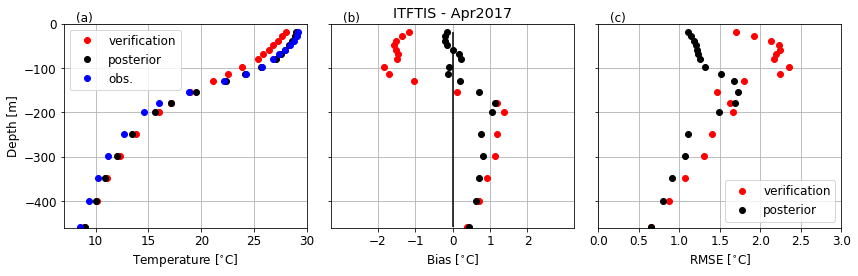

In [54]:

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
sitename = 'ITFTIS'
Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_TEMP_60s.nc'
dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso['TIME'].values, dso['TEMP'].values, dso['NOMINAL_DEPTH'].values)

########

# roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)
# romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)
# Vtransform=2
roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)


zobs = -Tobsraw.Z

# Load the file w/out DA
romsvar = 'temp'
Tmod = load_roms(romsfile, 'temp', zobs)
Tmod_da = load_roms(roms4dvarfile, 'temp', zobs)
dt = (Tmod.t[1] - Tmod.t[0]).astype('timedelta64[s]').astype(float)

def plot_dates(t1,t2, mydatestr):
    
    Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

    mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

    mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
                Z=-zobs, units='degC', varname='romsvar', interpmodel=False)
    
    plt.figure(figsize=(12,4))
    titlestr = '{} - {}'.format(sitename, mydatestr)
    plot_da(mo_T, mo_T_da, titlestr, ymin=-460)
    outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}_v4.png'.format(sitename, mydatestr.strip(' '))
    print(outfile)
    return outfile


####


# outfile=plot_dates(np.datetime64('2017-02-04 00:00:00'),np.datetime64('2017-03-01 00:00:00'),'Feb2017')
# plt.savefig(outfile, dpi=150)
# outfile=plot_dates(np.datetime64('2017-03-01 00:00:00'),np.datetime64('2017-04-01 00:00:00'),'Mar2017')
# plt.savefig(outfile, dpi=150)
outfile=plot_dates(np.datetime64('2017-04-01 00:00:00'),np.datetime64('2017-05-01 00:00:00'),'Apr2017')
plt.savefig(outfile, dpi=150)
# outfile=plot_dates(np.datetime64('2017-05-01 00:00:00'),np.datetime64('2017-06-01 00:00:00'),'May2017')
# plt.savefig(outfile, dpi=150)

# outfile=plot_dates(np.datetime64('2017-03-01 00:00:00'),np.datetime64('2017-05-01 00:00:00'),'MarApr2017')
# plt.savefig(outfile, dpi=150)

# plt.savefig(outfile, dpi=150)
# print(t1,t2)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


Mean bias (DA):  0.5145108774955967
Mean bias:  -0.19817903763913747
Mean rmse (DA):  1.5660880768291212
Mean rmse:  1.8176547000505694
../FIGURES/InSitu_T_validation_4Dvar_NP250_Apr2017_v5.png
Mean bias (DA):  0.6970391268157594
Mean bias:  0.1738052590533375
Mean rmse (DA):  1.8325306429896002
Mean rmse:  2.0057731150579956
../FIGURES/InSitu_T_validation_4Dvar_NP250_3-15Apr2017_v5.png
Mean bias (DA):  0.45002274190501884
Mean bias:  -0.4251191469047973
Mean rmse (DA):  1.5818142490312626
Mean rmse:  1.8247716641899392
../FIGURES/InSitu_T_validation_4Dvar_NP250_15-30Apr2017_v5.png


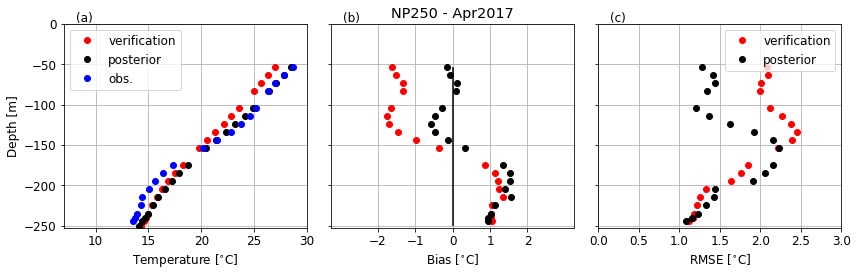

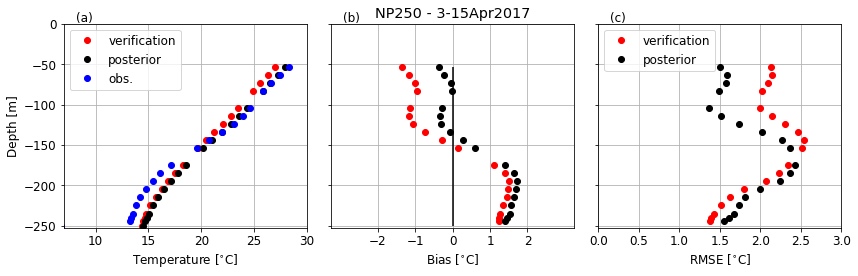

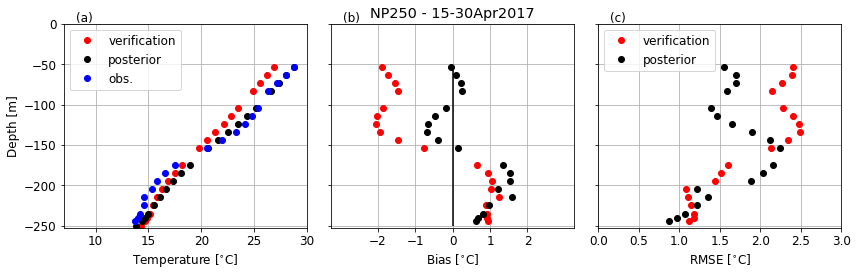

In [53]:

### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
sitename = 'NP250'
Tfile = '../DATA/UWA_KISSME_NP250_fixedheight_T.nc'
dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso['time'].values, dso['Temperature'].values[:-2,:], dso['depth'].values[:-2])

########


# roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)
# romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)
# Vtransform=2
roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)


zobs = -Tobsraw.Z

# Load the file w/out DA
romsvar = 'temp'
Tmod = load_roms(romsfile, 'temp', zobs)
Tmod_da = load_roms(roms4dvarfile, 'temp', zobs)
dt = (Tmod.t[1] - Tmod.t[0]).astype('timedelta64[s]').astype(float)

def plot_dates(t1,t2, mydatestr):
    
    Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

    mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

    mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
                Z=-zobs, units='degC', varname='romsvar', interpmodel=False)
    
    plt.figure(figsize=(12,4))
    titlestr = '{} - {}'.format(sitename, mydatestr)
    plot_da(mo_T, mo_T_da, titlestr)
    outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}_v5.png'.format(sitename, mydatestr.strip(' '))
    print(outfile)
    return outfile


####


outfile=plot_dates(np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-05-03 00:00:00'),'Apr2017')
plt.savefig(outfile, dpi=150)

outfile=plot_dates(np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-04-15 00:00:00'),'3-15Apr2017')
plt.savefig(outfile, dpi=150)

outfile=plot_dates(np.datetime64('2017-04-15 00:00:00'),np.datetime64('2017-04-30 00:00:00'),'15-30Apr2017')
plt.savefig(outfile, dpi=150)



# plt.savefig(outfile, dpi=150)
# print(t1,t2)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


Mean bias (DA):  0.6036699675179552
Mean bias:  -0.08792001164426015
Mean rmse (DA):  1.5810154201380429
Mean rmse:  1.7391412835532127
../FIGURES/InSitu_T_validation_4Dvar_SP250_Apr2017_v5.png
Mean bias (DA):  0.7416847156308508
Mean bias:  0.22826656877784737
Mean rmse (DA):  1.8579547454207639
Mean rmse:  2.0136044077468425
../FIGURES/InSitu_T_validation_4Dvar_SP250_3-15Apr2017_v5.png
Mean bias (DA):  0.5734873971176044
Mean bias:  -0.2820573851984894
Mean rmse (DA):  1.616660369209523
Mean rmse:  1.7068960597501217
../FIGURES/InSitu_T_validation_4Dvar_SP250_15-30Apr2017_v5.png


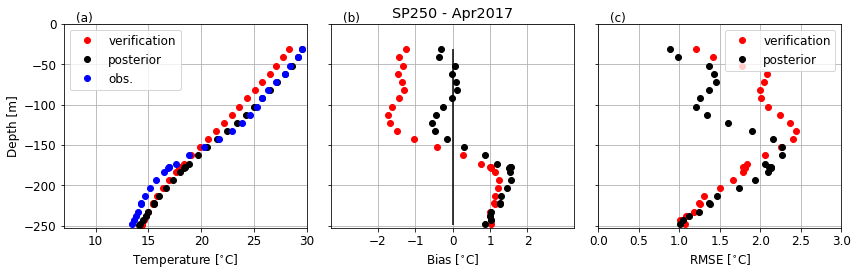

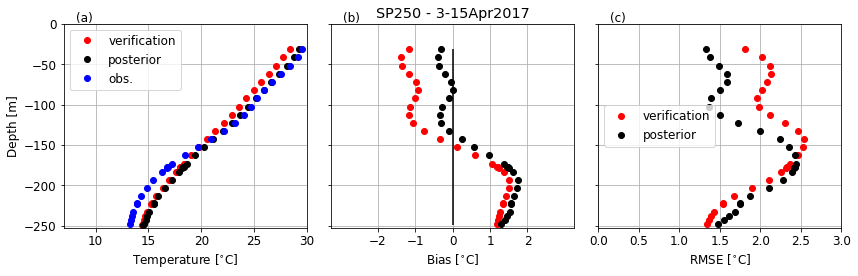

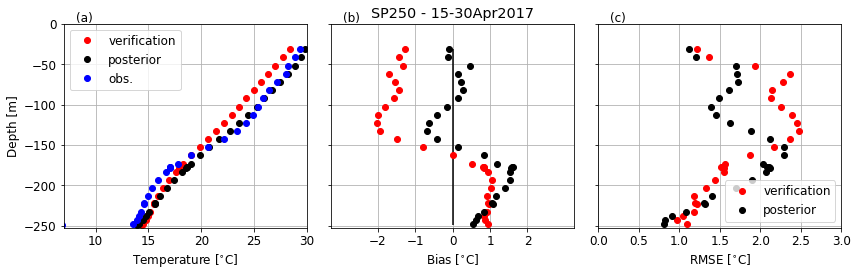

In [58]:
### Data loading varies between sites
#Tfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201607_TEMP_60s.nc' # The first few cycles are in this folder
sitename = 'SP250'
Tfile = '../DATA/UWA_KISSME_SP250_fixedheight_T.nc'
dso = xr.open_dataset(Tfile)
Tobsraw = om.OceanMooring(dso['time'].values, dso['Temperature'].values[:-1,:], dso['depth'].values[:-1])

########

# roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)
# romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)
# Vtransform=2
roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format('NP250')
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format('NP250')

zobs = -Tobsraw.Z

# Load the file w/out DA
romsvar = 'temp'
Tmod = load_roms(romsfile, 'temp', zobs)
Tmod_da = load_roms(roms4dvarfile, 'temp', zobs)
dt = (Tmod.t[1] - Tmod.t[0]).astype('timedelta64[s]').astype(float)

def plot_dates(t1,t2, mydatestr):
    
    Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

    mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

    mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
                Z=-zobs, units='degC', varname='romsvar', interpmodel=False)
    
    plt.figure(figsize=(12,4))
    titlestr = '{} - {}'.format(sitename, mydatestr)
    plot_da(mo_T, mo_T_da, titlestr)
    outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}_v5.png'.format(sitename, mydatestr.strip(' '))
    print(outfile)
    return outfile


####


outfile=plot_dates(np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-05-03 00:00:00'),'Apr2017')
plt.savefig(outfile, dpi=150)

outfile=plot_dates(np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-04-15 00:00:00'),'3-15Apr2017')
plt.savefig(outfile, dpi=150)

outfile=plot_dates(np.datetime64('2017-04-15 00:00:00'),np.datetime64('2017-04-30 00:00:00'),'15-30Apr2017')
plt.savefig(outfile, dpi=150)



# plt.savefig(outfile, dpi=150)
# print(t1,t2)

2017-04-01T11:31:00.000003000 2017-04-12T01:48:00.000003000
Mean bias (DA):  0.06811163743272666
Mean bias:  -1.4006813231010926
Mean rmse (DA):  2.263381006560766
Mean rmse:  2.727318734186258
../FIGURES/InSitu_T_validation_4Dvar_BRB200_1-15-Apr2017_v4.png


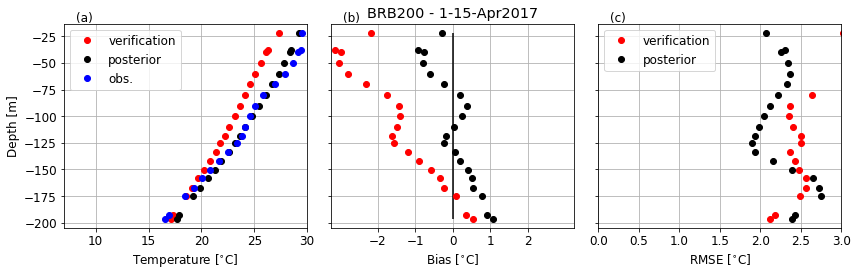

In [10]:
#####
# BRB Site
sitename = 'BRB200'
Tfile = '/home/mrayson/group/mrayson/DATA/FIELD/KISSME/KISSME_Gridded_Mooring_T_BRB.nc'
dso = xr.open_dataset(Tfile, group='BRB200')
Tobsraw = om.OceanMooring(dso['time'].values, dso['temperature'].values, dso['depth'].values-200.0)
print(Tobsraw.t[0],Tobsraw.t[-1])
######

# roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)
# romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)
# Vtransform=2
roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)

zobs = Tobsraw.Z

# Load the file w/out DA
romsvar = 'temp'
Tmod = load_roms(romsfile, 'temp', zobs)
Tmod_da = load_roms(roms4dvarfile, 'temp', zobs)
dt = (Tmod.t[1] - Tmod.t[0]).astype('timedelta64[s]').astype(float)

def plot_dates(t1,t2, mydatestr):
    
    Tobs = Tobsraw.clip(t1,t2).resample(dt,ndt=1)

    mo_T = ModVsObs(Tmod.t, Tmod.y, Tobs.t, Tobs.y, \
            Z=-zobs, units='degC', varname='romsvar', interpmodel=False)

    mo_T_da = ModVsObs(Tmod_da.t, Tmod_da.y, Tobs.t, Tobs.y, \
                Z=-zobs, units='degC', varname='romsvar', interpmodel=False)
    
    plt.figure(figsize=(12,4))
    titlestr = '{} - {}'.format(sitename, mydatestr)
    plot_da(mo_T, mo_T_da, titlestr)
    outfile = '../FIGURES/InSitu_T_validation_4Dvar_{}_{}_v4.png'.format(sitename, mydatestr.strip(' '))
    print(outfile)
    return outfile


####


outfile=plot_dates(np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-04-12 00:00:00'),'1-15-Apr2017')
plt.savefig(outfile, dpi=150)



# Compare velocity data

In [83]:
def load_uv_BRB200(obsvar):
    uvfile = '/home/mrayson/group/mrayson/DATA/FIELD/KISSME/KISSME2017_RDI_QAQC_noerrvel.nc'
    group = 'BRB200_RDI_150_kHz_Quartermaster_16752'

    dso = xr.open_dataset(uvfile, group=group)

    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.zhat.mean(axis=1))
    zobs = -Uobsraw.Z - 10.
    xyin = np.array([dso.Longitude, dso.Latitude])

    return Uobsraw, zobs, xyin

def load_uv_SP250(obsvar):
    uvfile = '../DATA/UWA_KISSME_SP250_fixedheight_uv.nc'

    dso = xr.open_dataset(uvfile)
    dso
    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.depth.values)
    zobs = -Uobsraw.Z
    xyin = np.array([dso.X, dso.Y])
    return Uobsraw, zobs, xyin

def load_uv_ITFTIS(obsvar):
    uvfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_UV.nc'
    dso = xr.open_dataset(uvfile)
    zobs = (-dso['NOMINAL_DEPTH'] + dso['HEIGHT_ABOVE_SENSOR']).values[:-6]
    U = dso[obsvar].values[:,:-6]
    print(U.shape)
    #print(dso[obsvar].values.shape, zobs.shape, zobs, zobs[:-5])
    Uobsraw = om.OceanMooring(dso.TIME.values, U, zobs)
    xyin = np.array([dso.LONGITUDE.values, dso.LATITUDE.values])
    print('dt: ',(dso.TIME.values[1]-dso.TIME.values[0]).astype('timedelta64[s]'))
    return Uobsraw, Uobsraw.Z, xyin

In [81]:
def load_velocity_mo(romsfile,  roms4dvarfile, obsvar, romsvar, t1, t2, loadfunc, resample=True):
    
    Uobsraw, zobs, xyin = loadfunc(obsvar)
    
    # Load the file w/out DA
    Umod = load_roms(romsfile, romsvar, zobs)
    Umod_da = load_roms(roms4dvarfile, romsvar, zobs)

    dt = (Umod.t[1] - Umod.t[0]).astype('timedelta64[s]').astype(float)

    # #Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
    Uobs = Uobsraw.clip(t1,t2)
    if resample:
        Uobs=Uobs.resample(dt,ndt=1)

    print(zobs, Umod.y.shape, Uobs.y.shape)
    mo_U = ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)

    mo_U_da = ModVsObs(Umod_da.t, Umod_da.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)
    
    return mo_U, mo_U_da

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


[ -30.  -40.  -50.  -60.  -70.  -80.  -90. -100. -110. -120. -130. -140.
 -150. -160. -170. -180. -190. -200. -210. -220. -230.] (21, 5790) (21, 1441)


/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


[ -30.  -40.  -50.  -60.  -70.  -80.  -90. -100. -110. -120. -130. -140.
 -150. -160. -170. -180. -190. -200. -210. -220. -230.] (21, 5790) (21, 1441)
Mean rmse (DA):  0.13714282857511742
Mean rmse:  0.1687270561782372
Mean rmse (DA):  0.1411701935969643
Mean rmse:  0.1771090975143911


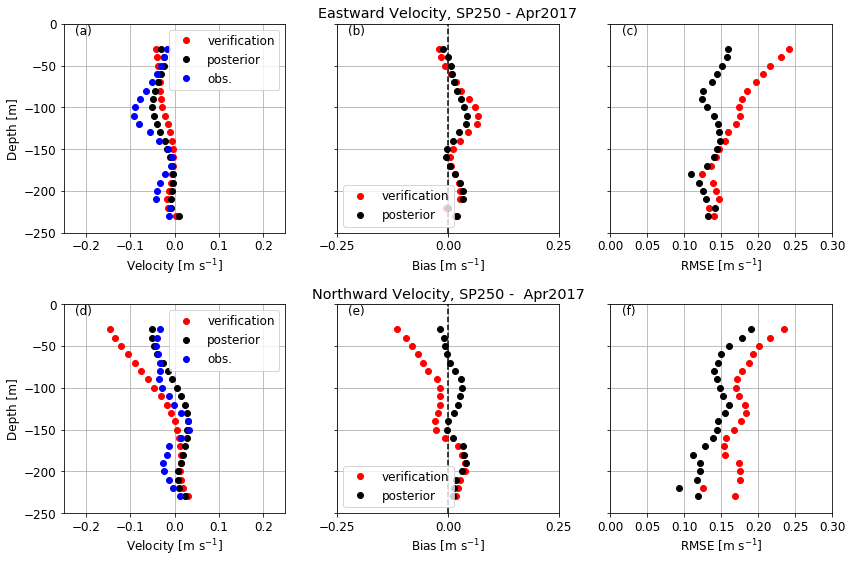

In [64]:
sitename = 'SP250'


# roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)
# romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)
# Vtransform=2
roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format('NP250')
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format('NP250')

t1,t2 = np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-05-03 00:00:00')
mydatestr = 'Apr2017'

mo_U, mo_U_da = load_velocity_mo(romsfile,roms4dvarfile, 'u', 'u_eastward', t1,t2, load_uv_SP250)
mo_V, mo_V_da = load_velocity_mo(romsfile,roms4dvarfile, 'v', 'v_northward', t1,t2, load_uv_SP250)

# ####
plt.figure(figsize=(12,8))
titlestr = 'Eastward Velocity, {} - {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_U, mo_U_da, titlestr, nrows=2, startrow=0)

#plt.figure(figsize=(12,4))
titlestr = 'Northward Velocity, {} -  {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_V, mo_V_da, titlestr, nrows=2, startrow=1, labels=('(d)','(e)','(f)'))

outfile = '../FIGURES/InSitu_UV_validation_4Dvar_{}_{}_v5.png'.format(sitename, mydatestr.strip(' '))
plt.savefig(outfile, dpi=150)

# # plot the surface velocty
# sfcidx = 0
# mo_U.Z[sfcidx]
# ylim=(-0.8,0.8)

# plt.figure(figsize=(12,6))
# ax=plt.subplot(211)

# plt.plot(mo_U_da.TSobs.t, mo_U_da.TSobs.y[sfcidx,:], 'b')
# plt.plot(mo_U.TSmod.t, mo_U.TSmod.y[sfcidx,:], 'r')
# plt.plot(mo_U_da.TSmod.t, mo_U_da.TSmod.y[sfcidx,:], 'k')
# plt.ylim(ylim)
# plt.xlim((t1,t2))

# plt.grid(b=True,ls=':')
# ax.set_xticklabels('')
# plt.ylabel('u [m/s]')
# plt.legend(('Obs.','ROMS','ROMS-4DVAR'), loc='upper right')

# plt.subplot(212)

# plt.plot(mo_V_da.TSobs.t, mo_V_da.TSobs.y[sfcidx,:], 'b')
# plt.plot(mo_V.TSmod.t, mo_V.TSmod.y[sfcidx,:], 'r')
# plt.plot(mo_V_da.TSmod.t, mo_V_da.TSmod.y[sfcidx,:], 'k')
# plt.ylim(ylim)
# plt.xlim((t1,t2))
# plt.grid(b=True,ls=':')
# plt.ylabel('v [m/s]')
# plt.xlabel('Date in 2017 [mm-dd HH]')

# outfile = '../FIGURES/InSitu_surfaceUV_timeseries_4Dvar_{}_{}.png'.format(stationT, days[fileno])
# plt.savefig(outfile, dpi=150)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


<xarray.DataArray 'zhat' (distance: 45)>
array([-184.87724933, -180.98380856, -177.09036778, -173.196927  ,
       -169.30348622, -165.41004545, -161.51660467, -157.62316389,
       -153.72972311, -149.83628234, -145.94284156, -142.04940078,
       -138.15596   , -134.26251923, -130.36907845, -126.47563767,
       -122.58219689, -118.68875612, -114.79531534, -110.90187456,
       -107.00843378, -103.11499301,  -99.22155223,  -95.32811145,
        -91.43467067,  -87.5412299 ,  -83.64778912,  -79.75434834,
        -75.86090756,  -71.96746679,  -68.07402601,  -64.18058523,
        -60.28714445,  -56.39370368,  -52.5002629 ,  -48.60682212,
        -44.71338134,  -40.81994057,  -36.92649979,  -33.03305901,
        -29.13961823,  -25.24617746,  -21.35273668,  -17.4592959 ,
        -13.56585512])
Coordinates:
  * distance  (distance) float64 8.4 12.4 16.4 20.4 ... 172.4 176.4 180.4 184.4 (45, 5790) (45, 673)


/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


<xarray.DataArray 'zhat' (distance: 45)>
array([-184.87724933, -180.98380856, -177.09036778, -173.196927  ,
       -169.30348622, -165.41004545, -161.51660467, -157.62316389,
       -153.72972311, -149.83628234, -145.94284156, -142.04940078,
       -138.15596   , -134.26251923, -130.36907845, -126.47563767,
       -122.58219689, -118.68875612, -114.79531534, -110.90187456,
       -107.00843378, -103.11499301,  -99.22155223,  -95.32811145,
        -91.43467067,  -87.5412299 ,  -83.64778912,  -79.75434834,
        -75.86090756,  -71.96746679,  -68.07402601,  -64.18058523,
        -60.28714445,  -56.39370368,  -52.5002629 ,  -48.60682212,
        -44.71338134,  -40.81994057,  -36.92649979,  -33.03305901,
        -29.13961823,  -25.24617746,  -21.35273668,  -17.4592959 ,
        -13.56585512])
Coordinates:
  * distance  (distance) float64 8.4 12.4 16.4 20.4 ... 172.4 176.4 180.4 184.4 (45, 5790) (45, 673)
Mean rmse (DA):  0.16303756520581508
Mean rmse:  0.15487761185288018
Mean rmse (DA): 

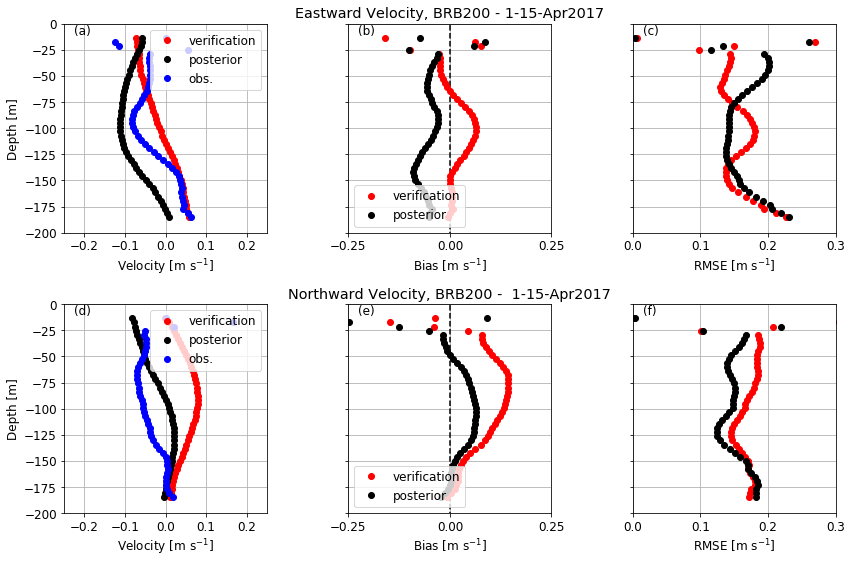

In [85]:
sitename = 'BRB200'

# roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)
# romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)
# Vtransform=2
roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)

t1,t2 = np.datetime64('2017-04-01 00:00:00'),np.datetime64('2017-04-15 00:00:00')
mydatestr = '1-15-Apr2017'

# t1,t2 = np.datetime64('2017-04-15 00:00:00'),np.datetime64('2017-05-01 00:00:00')
# mydatestr = '15-30-Apr2017'

mo_U, mo_U_da = load_velocity_mo(romsfile,roms4dvarfile, 'u', 'u_eastward', t1,t2, load_uv_BRB200)
mo_V, mo_V_da = load_velocity_mo(romsfile,roms4dvarfile, 'v', 'v_northward', t1,t2, load_uv_BRB200)

# ####
plt.figure(figsize=(12,8))
titlestr = 'Eastward Velocity, {} - {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_U, mo_U_da, titlestr, nrows=2, startrow=0, ymin=-200)

#plt.figure(figsize=(12,4))
titlestr = 'Northward Velocity, {} -  {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_V, mo_V_da, titlestr, nrows=2, startrow=1, ymin=-200, labels=('(d)','(e)','(f)'))

outfile = '../FIGURES/InSitu_UV_validation_4Dvar_{}_{}_v4.png'.format(sitename, mydatestr.strip(' '))
plt.savefig(outfile, dpi=150)


(11738, 27)
dt:  1199 seconds
[-431.43     -416.43     -401.43     -386.43     -371.43     -356.43
 -341.43     -326.43     -311.43     -296.43     -281.43     -266.43
 -251.43001  -236.43001  -221.43001  -206.43001  -191.43     -176.43
 -161.43     -146.43     -131.43     -116.42999  -101.42999   -86.42999
  -71.42999   -56.429993  -41.429993] (27, 5790) (27, 2161)
(11738, 27)
dt:  1199 seconds
[-431.43     -416.43     -401.43     -386.43     -371.43     -356.43
 -341.43     -326.43     -311.43     -296.43     -281.43     -266.43
 -251.43001  -236.43001  -221.43001  -206.43001  -191.43     -176.43
 -161.43     -146.43     -131.43     -116.42999  -101.42999   -86.42999
  -71.42999   -56.429993  -41.429993] (27, 5790) (27, 2161)
Mean rmse (DA):  0.14429099619855273
Mean rmse:  0.15435832318560241
Mean rmse (DA):  0.1515950912654913
Mean rmse:  0.15915389881542913


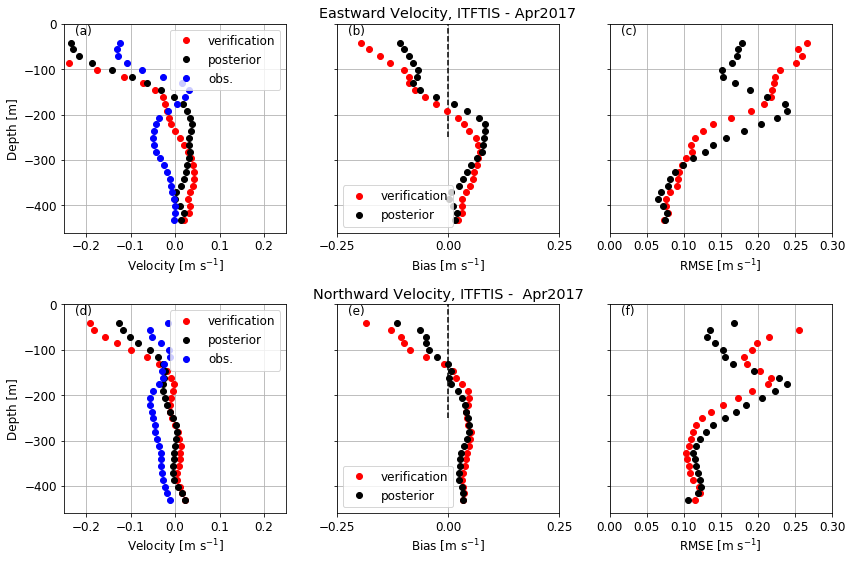

In [84]:
sitename = 'ITFTIS'

# roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}.nc'.format(sitename)
# romsfile = '../DATA/ROMS_NL_station_{}.nc'.format(sitename)
# Vtransform=2
roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)

t1,t2 = np.datetime64('2017-04-01 00:00:00'),np.datetime64('2017-05-01 00:00:00')
mydatestr = 'Apr2017'

# t1,t2 = np.datetime64('2017-03-01 00:00:00'),np.datetime64('2017-04-01 00:00:00')
# mydatestr = 'Mar2017'

# t1,t2 = np.datetime64('2017-04-15 00:00:00'),np.datetime64('2017-05-15 00:00:00')
# mydatestr = 'May2017'

mo_U, mo_U_da = load_velocity_mo(romsfile,roms4dvarfile, 'u', 'u_eastward', t1,t2, load_uv_ITFTIS, resample=False)
mo_V, mo_V_da = load_velocity_mo(romsfile,roms4dvarfile, 'v', 'v_northward', t1,t2, load_uv_ITFTIS, resample=False)

# ####
plt.figure(figsize=(12,8))
titlestr = 'Eastward Velocity, {} - {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_U, mo_U_da, titlestr, nrows=2, startrow=0, ymin=-460)

#plt.figure(figsize=(12,4))
titlestr = 'Northward Velocity, {} -  {}'.format(sitename, mydatestr.strip(' '))
plot_da_uv(mo_V, mo_V_da, titlestr, nrows=2, startrow=1, ymin=-460, labels=('(d)','(e)','(f)'))

outfile = '../FIGURES/InSitu_UV_validation_4Dvar_{}_{}_v5.png'.format(sitename, mydatestr.strip(' '))
plt.savefig(outfile, dpi=150)
